In [1]:
%pip install opencv-python-headless pandas numpy pillow requests python-docx matplotlib tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.4 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install pymupdf
!pip install python-docx
!pip install jiwer
!apt-get install -y tesseract-ocr
!pip install pytesseract


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 81.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 40.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 129 not upgraded.


## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import csv
import os
import fitz
import cv2
from docx import Document
import string
import requests
from PIL import Image, ImageOps
import tensorflow.data as tfd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.utils import plot_model

In [3]:
rm -rf /kaggle/working/*


## Extracting individual pages from the source pdf

In [4]:
def get_images_from_pdf(pdf_path, output_folder):
    pdf_doc = fitz.open(pdf_path)
    totalpages=len(pdf_doc)
    for page_num in range(totalpages):
        page = pdf_doc.load_page(page_num)
        pixmap = page.get_pixmap()
        image_path = os.path.join(output_folder, f'page_{page_num + 1}.png')
        pixmap.save(image_path)

    pdf_doc.close()

pdf = "/kaggle/input/pdf-buendia/Buendia - Instruccion.pdf"  # PDF
images_folder = "/kaggle/working/imgs_pdf1"  # Output folder to save images
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
get_images_from_pdf(pdf, images_folder)

## Splitting each page vertically
### This is because the pdf used for text recognition here has 2 pages side by side in one image.In general we can decide whether to split or not based on the image width

In [5]:
def split_all_images_vertically(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)
            width, height = image.size

            # Defining left and right halves
            left_half = image.crop((0, 0, width // 2, height))  # Left half
            right_half = image.crop((width // 2, 0, width, height))  # Right half

            # Saving the split images
            base_name = os.path.splitext(filename)[0]
            left_half.save(os.path.join(output_folder, f"{base_name}_left.png"), "PNG")
            right_half.save(os.path.join(output_folder, f"{base_name}_right.png"), "PNG")

            print(f"Split images saved: {base_name}_left.png, {base_name}_right.png")

split_all_images_vertically("/kaggle/working/imgs_pdf1", "/kaggle/working/split_images")

Split images saved: page_6_left.png, page_6_right.png
Split images saved: page_2_left.png, page_2_right.png
Split images saved: page_3_left.png, page_3_right.png
Split images saved: page_1_left.png, page_1_right.png
Split images saved: page_5_left.png, page_5_right.png
Split images saved: page_4_left.png, page_4_right.png


In [6]:
#Retrieving sorted image file paths from split_images_dir, 
# excluding the first and last images since first is blank and last is for inference
split_images_dir = "/kaggle/working/split_images"

all_files = sorted(os.listdir(split_images_dir))

image_files = [f for f in all_files if f.endswith(".png")]

image_paths = [os.path.join(split_images_dir, f) for f in image_files]

image_paths = image_paths[1:-1]  

print("Image Paths:", image_paths)

Image Paths: ['/kaggle/working/split_images/page_1_right.png', '/kaggle/working/split_images/page_2_left.png', '/kaggle/working/split_images/page_2_right.png', '/kaggle/working/split_images/page_3_left.png', '/kaggle/working/split_images/page_3_right.png', '/kaggle/working/split_images/page_4_left.png', '/kaggle/working/split_images/page_4_right.png', '/kaggle/working/split_images/page_5_left.png', '/kaggle/working/split_images/page_5_right.png', '/kaggle/working/split_images/page_6_left.png']


## Preparing the training word images from all extracted pages

In [8]:
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow

# Load image
output_dir = "./words_output"
os.makedirs(output_dir, exist_ok=True)
word_data = []

for image_path in image_paths:
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  gray=image
  # Performing OCR with bounding boxes
  custom_config = r'--oem 3 --psm 6' 
  data = pytesseract.image_to_data(gray, config=custom_config, output_type=Output.DICT)

  # Processing each word
  for i in range(len(data['text'])):
      text = data['text'][i].strip()
      if text:
          x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]

          # Extracting word image
          word_img = image[y:y+h, x:x+w]

          # Saving image with text as filename
          word_filename = f"{output_dir}/{text}_{i}.png"
          cv2.imwrite(word_filename, word_img)

          # Storing file path and label in list to later add to a df
          word_data.append((word_filename, text))

          # Drawing bounding boxes on the main image
          cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
          cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

df = pd.DataFrame(word_data, columns=["Image_Path", "Label"])

# Cleaning the df to get rid of corrupted paths
df = df[df["Image_Path"].apply(os.path.exists)]

# Reseting index after filtering
df = df.reset_index(drop=True)
df.to_csv("word_labels.csv", index=False)

print("preapred an initial df with image path and corresponding labels")

preapred an initial df with image path and corresponding labels


## Data augmentation

### Rotating the images

In [9]:
def rotation_images(df, output_dir):

    os.makedirs(output_dir, exist_ok=True)

    augmented_data = []  # to store (image_path, label)
    # Iterating through the df of all extracted images
    for _, row in df.iterrows():
        image_path, label = row["Image_Path"], row["Label"]

        if image_path.endswith(('.png', '.jpg', '.jpeg')):
            with Image.open(image_path) as img:
                # Rotating images from -5 to 5 degrees to generate 10 more for each
                for angle in range(-5, 6):
                    if angle == 0:
                        continue

                    # Rotating image
                    rotated_img = img.rotate(angle, expand=True)

                    # Generating new filename
                    base_name = os.path.splitext(os.path.basename(image_path))[0]
                    new_filename = f"{base_name}_rotation_by_{angle}.png"
                    new_path = os.path.join(output_dir, new_filename)

                    # Saving rotated image
                    rotated_img.save(new_path)

                    # Storing new path & label
                    augmented_data.append((new_path, label))

    return augmented_data

In [10]:
output_dir = "/kaggle/working/rotated_images"
rotated_list = rotation_images(df, output_dir)

# Convert list to dataframe
rotated_df = pd.DataFrame(rotated_list, columns=["Image_Path", "Label"])

rotated_df.to_csv("rotated_df.csv", index=False)

print("added rotated images")

added rotated images


In [11]:
print(len(rotated_df))

14530


### Adding noise to images

In [12]:
def gaussian_noise(image, mean=0, var=0.01):
    sigma = var ** 0.5  # Standard deviation
    gauss = np.random.normal(mean, sigma, image.shape) * 255  # Scale noise
    noisy_image = np.clip(image + gauss, 0, 255).astype(np.uint8)  # Add noise & clip

    return noisy_image

def augment_with_noise(df, output_dir, mean=0, var=0.01):
    os.makedirs(output_dir, exist_ok=True)
    augmented_data_noise = []

    for _, row in df.iterrows():
        image_path, label = row["Image_Path"], row["Label"]

        if not os.path.exists(image_path):
            print(f"Skipping missing file: {image_path}")
            continue 

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Skipping unreadable file: {image_path}")
            continue  # Skipping corrupt images

        # Gaussian noise
        noisy_image = gaussian_noise(image, mean, var)

        base_name = os.path.splitext(os.path.basename(image_path))[0]
        new_filename = f"{base_name}_with_noise.png"
        new_path = os.path.join(output_dir, new_filename)
        cv2.imwrite(new_path, noisy_image)

        # Storing new path & label in a list to later add it to a dataframe
        augmented_data_noise.append((new_path, label))

    return augmented_data_noise

In [13]:
output_dir = "/kaggle/working/noisy_images"
augmented_list = augment_with_noise(df, output_dir)

# Converting list to datafrane
augmented_df_noise = pd.DataFrame(augmented_list, columns=["Image_Path", "Label"])
augmented_df_noise.to_csv("noisy_labels.csv", index=False)

print("Gaussian noise images added.")

Gaussian noise images added.


In [14]:
print(len(augmented_df_noise))

1453


### Sharpening code ( can be uncommented and used)

In [15]:
# def sharpen_image(image):
#     kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  
#     sharpened = cv2.filter2D(image, -1, kernel)
#     return np.clip(sharpened, 0, 255).astype(np.uint8)

# def augment_with_sharpening(df, output_dir):
#     os.makedirs(output_dir, exist_ok=True)
#     augmented_data_sharp = []

#     for _, row in df.iterrows():
#         image_path, label = row["Image_Path"], row["Label"]

#         image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#         if image is None:
#             print(f"Skipping unreadable file: {image_path}")
#             continue  # Skip corrupt images

#         sharpened_image = sharpen_image(image)

#         # This saves new sharpened image
#         base_name = os.path.splitext(os.path.basename(image_path))[0]
#         new_filename = f"{base_name}_sharpened.png"
#         new_path = os.path.join(output_dir, new_filename)
#         cv2.imwrite(new_path, sharpened_image)

#         # Stores new path & label
#         augmented_data_sharp.append((new_path, label))

#     return augmented_data_sharp

# output_dir = "/kaggle/working/sharpened_images"
# sharpened_list = augment_with_sharpening(df, output_dir)

# augmented_df_sharp = pd.DataFrame(sharpened_list, columns=["Image_Path", "Label"])
# augmented_df_sharp.to_csv("sharpened_labels.csv", index=False)

# print("Sharpened images added.")



### Combining original, rotated and augmented images

In [16]:

# combing all 3 dfs - original,rotated,gaussian_noise
combined_df = pd.concat([df, rotated_df, augmented_df_noise], ignore_index=True)  # Resets index

# Save the combined DataFrame
combined_df.to_csv("combined_dataset.csv", index=False)

print(f"Total images in combined dataset: {len(combined_df)}")


Total images in combined dataset: 17436


## Analysing image dimensions 
### Computing summary statistics and percentiles (90th to 99th) for width and height of all training images to determine the ideal padding dimensions for resizing while maintaining aspect ratio

In [17]:
image_sizes = []

for index, row in combined_df.iterrows():
    image_path = row["Image_Path"]

    image = cv2.imread(image_path)

    if image is not None:
        h, w, _ = image.shape  # Get height and width
        image_sizes.append([h, w])
    else:
        print(f"Error loading image: {image_path}")  # Handle missing/corrupt images

# Create DataFrame from the list
img_sizes_df = pd.DataFrame(image_sizes, columns=["Height", "Width"])

# Display the DataFrame
print(img_sizes_df)


       Height  Width
0          39     25
1         161    109
2          19     59
3          49      5
4          12      9
...       ...    ...
17431      30     69
17432      31     53
17433      40     39
17434      39    152
17435      31    118

[17436 rows x 2 columns]


In [18]:
img_sizes_df.describe()

,Height,Width
count,17436.000000,17436.000000
mean,34.055288,74.917642
std,11.732167,49.234420
min,2.000000,1.000000
25%,30.000000,36.000000
50%,33.000000,63.000000
75%,39.000000,110.000000
max,171.000000,280.000000


In [19]:
for i in range(10):
    print("Train Images Width "+str(90+i)+ " percentile :",np.percentile(img_sizes_df['Width'].values,90+i))
print("="*60)

Train Images Width 90 percentile : 148.0
Train Images Width 91 percentile : 152.0
Train Images Width 92 percentile : 155.0
Train Images Width 93 percentile : 158.0
Train Images Width 94 percentile : 163.0
Train Images Width 95 percentile : 168.0
Train Images Width 96 percentile : 174.0
Train Images Width 97 percentile : 179.95000000000073
Train Images Width 98 percentile : 188.0
Train Images Width 99 percentile : 200.0


In [20]:
for i in range(10):
    print("Train Images Height "+str(90+i)+ " percentile :",np.percentile(img_sizes_df['Height'].values,90+i))
print("="*60)

Train Images Height 90 percentile : 47.0
Train Images Height 91 percentile : 48.0
Train Images Height 92 percentile : 49.0
Train Images Height 93 percentile : 49.0
Train Images Height 94 percentile : 51.0
Train Images Height 95 percentile : 52.0
Train Images Height 96 percentile : 53.0
Train Images Height 97 percentile : 55.0
Train Images Height 98 percentile : 58.0
Train Images Height 99 percentile : 65.0


### Setting a taregt height and width for padding based on the above analysis 

In [22]:
# BASED ON THIS 160(HEIGHT) AND 50(WIDTH) SEEM THE RIGHT CHOICES FOR SCALING
target_h=50
target_w=160

# Gathering all images and applying padding
### Processes original, rotated and noised images
### Resizing them while maintaining their aspect ratio and applying padding to match the target dimensions
### The padded images are then converted to grayscale and saved in an output directory.

Total images collected: 16908
Target dimensions decided based on analysis : h = 50, w = 160
Saved: /kaggle/working/training_images/Don_52_with_noise.png


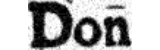

In [23]:
from google.colab.patches import cv2_imshow
import typing

# white as padding colour
padding_color: typing.Tuple[int] = (255, 255, 255)

input_dirs = ["/kaggle/working/words_output", "/kaggle/working/rotated_images", "/kaggle/working/noisy_images"]

image_paths = []

# Looping through each directory and collect image paths
for input_dir in input_dirs:
    if os.path.exists(input_dir): 
        images = [os.path.join(input_dir, img) for img in os.listdir(input_dir)
                  if img.endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(images)  
    else:
        print(f"Warning: Directory {input_dir} does not exist.")

# number of images found
print(f"Total images collected: {len(image_paths)}")

print(f"Target dimensions decided based on analysis : h = {target_h}, w = {target_w}" )

# Applying padding to each image
output_dir = "/kaggle/working/training_images"
os.makedirs(output_dir, exist_ok=True)

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Skipping {img_path}, could not load image.")
        continue

    old_h, old_w = img.shape[:2]

    # Resizing while maintaining aspect ratio
    ratio = min(target_w / old_w, target_h / old_h)
    new_w, new_h = int(old_w * ratio), int(old_h * ratio)
    resized_image = cv2.resize(img, (new_w, new_h))

    # Computing padding
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Applying padding
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    
    # Converting to grayscale and saving
    gray_padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)
    
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_path, gray_padded_image)

print(f"Saved: {output_path}")

# Showing an example
cv2_imshow(gray_padded_image)


In [24]:
# checking if padding has been applied correctly

img_dir = "/kaggle/working/training_images"
image_paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

# Printing shape of 10 images
for img_path in image_paths[:10]:
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
    if img is not None:
        print(f"Image: {os.path.basename(img_path)}, Shape: {img.shape}")  # Printing filename and shape
    else:
        print(f"Warning: Could not read {img_path}")


Image: 4_179_with_noise.png, Shape: (50, 160)
Image: conciencia_148_with_noise.png, Shape: (50, 160)
Image: enten-_128_rotation_by_-5.png, Shape: (50, 160)
Image: efte_78_rotation_by_-4.png, Shape: (50, 160)
Image: no_139_rotation_by_3.png, Shape: (50, 160)
Image: D._102_rotation_by_-2.png, Shape: (50, 160)
Image: la_30_rotation_by_5.png, Shape: (50, 160)
Image: prove-_72_rotation_by_3.png, Shape: (50, 160)
Image: pues_36_rotation_by_-2.png, Shape: (50, 160)
Image: Divi-_156_rotation_by_3.png, Shape: (50, 160)


### Finding necessary parameters like max label length, total characters

In [25]:
all_chars = set(ch for label in combined_df["Label"] for ch in label)
total_classes = len(all_chars)

print(f"Total characters: {total_classes}")
print(f"All Characters: \n{all_chars}")

Total characters: 91
All Characters: 
{'B', 'u', '4', 'T', 'n', 'V', 'd', '+', '=', 's', 'q', '6', '{', '©', '0', '“', ':', 'Q', 'w', 'b', 'D', 'j', 'Z', 't', ';', 'e', '7', '*', '3', 'A', '-', 'O', '2', 'x', 'E', 'g', '_', 'Y', 'v', '8', 'H', '~', '.', 'y', 'p', 'R', ')', '<', 'M', '!', '\\', '"', '@', 'F', 'h', '¥', '’', 'N', '«', 'J', 'o', '°', '¢', '1', 'G', 'f', '5', 'P', '(', 'c', 'a', '%', 'l', ',', '|', 'r', 'm', "'", 'é', '£', 'I', '9', 'L', 'S', 'C', 'U', '&', 'i', 'K', 'z', '‘'}


In [26]:
max_label_length = max(combined_df["Label"].apply(len))
print(f"Max true label length: {max_label_length}")


Max true label length: 16


In [27]:
combined_df.head()

,Image_Path,Label
0,./words_output/x_4.png,x
1,./words_output/+_5.png,+
2,"./words_output/""3_6.png","""3"
3,./words_output/R_8.png,R
4,"./words_output/,_9.png",","


## Splitting data into 80% train,20% valid

In [28]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("combined_dataset.csv")

train_csv, valid_csv = train_test_split(df, test_size=0.20, random_state=42)

train_csv.to_csv("train.csv", index=False)
valid_csv.to_csv("valid.csv", index=False)

print("data has been split")


data has been split


### Making the mapping dictionaries for character to number

In [29]:
# Character to number
char_to_num = layers.StringLookup(vocabulary = list(all_chars),mask_token = None)

# Reverse mapping
num_to_char = layers.StringLookup(vocabulary = char_to_num.get_vocabulary(),mask_token = None,invert = True)

In [30]:
print("Mapping:")
for char in all_chars:
    print(f"'{char}': {char_to_num(tf.constant(char)).numpy()}")


Mapping:
'B': 1
'u': 2
'4': 3
'T': 4
'n': 5
'V': 6
'd': 7
'+': 8
'=': 9
's': 10
'q': 11
'6': 12
'{': 13
'©': 14
'0': 15
'“': 16
':': 17
'Q': 18
'w': 19
'b': 20
'D': 21
'j': 22
'Z': 23
't': 24
';': 25
'e': 26
'7': 27
'*': 28
'3': 29
'A': 30
'-': 31
'O': 32
'2': 33
'x': 34
'E': 35
'g': 36
'_': 37
'Y': 38
'v': 39
'8': 40
'H': 41
'~': 42
'.': 43
'y': 44
'p': 45
'R': 46
')': 47
'<': 48
'M': 49
'!': 50
'\': 51
'"': 52
'@': 53
'F': 54
'h': 55
'¥': 56
'’': 57
'N': 58
'«': 59
'J': 60
'o': 61
'°': 62
'¢': 63
'1': 64
'G': 65
'f': 66
'5': 67
'P': 68
'(': 69
'c': 70
'a': 71
'%': 72
'l': 73
',': 74
'|': 75
'r': 76
'm': 77
''': 78
'é': 79
'£': 80
'I': 81
'9': 82
'L': 83
'S': 84
'C': 85
'U': 86
'&': 87
'i': 88
'K': 89
'z': 90
'‘': 91


## Converting image to tensor 

#### Converts an image to a grayscale tensor, normalizes it, resizes it, and transposes its dimensions

In [31]:
def image_to_tensor(image_path : str):
   
    image = tf.io.read_file(image_path)
    decoded = tf.image.decode_jpeg(contents = image, channels = 1)
    temp = tf.image.convert_image_dtype(image = decoded, dtype = tf.float32)
    resized_image = tf.image.resize(images = temp, size = (target_h, target_w))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # Converting image to a tensor.
    image = tf.cast(image, dtype = tf.float32)

    return image

## Processes each image 

#### Processes an image and its label by converting the image to a tensor, encoding the label as character indices, and padding it to a fixed length.

In [32]:
def process_sample(image_path : str, label : str):
    # Getting the image
    image = image_to_tensor(image_path)
    # Converting label into char vectors
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    processed = char_to_num(chars)

    # Padding to max label elngth using the unk character
    padding_len = max_label_length - tf.shape(processed)[0]
    processed = tf.pad(processed, paddings = [[0, padding_len]], constant_values=total_classes+3)

    return {'image':image, 'label':processed}

## Converts predictions to text
#### Decodes model predictions into text by applying CTC decoding, converting numeric sequences to characters, joining them into words, and removing unknown tokens.

In [33]:
def convert_predictions_to_text(predictions):
    seq_lengths = np.ones(shape=predictions.shape[0]) * predictions.shape[1]
    decoded_output = keras.backend.ctc_decode(predictions, input_length=seq_lengths, greedy=True)[0][0][:, :max_label_length]

    # numeric to char to word
    char_sequences = num_to_char(decoded_output)
    final_texts = [tf.strings.reduce_join(inputs=seq).numpy().decode('UTF-8') for seq in char_sequences]

    # Removing unknown tokens
    cleaned_texts = [text.replace('[UNK]', " ").strip() for text in final_texts]

    return cleaned_texts

### Creating TensorFlow datasets for training and validation by shuffling, processing, batching, and prefetching image-label pairs.

In [34]:
import tensorflow as tf

batch_size = 8
autotune = tf.data.AUTOTUNE
train_size = len(train_csv)

# Training data
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(train_csv['Image_Path'].to_list()), np.array(train_csv['Label'].to_list()))
).shuffle(train_size).map(process_sample, num_parallel_calls=autotune).batch(batch_size).prefetch(autotune)

# Validation data
valid_dataset = tf.data.Dataset.from_tensor_slices((np.array(valid_csv['Image_Path'].to_list()), np.array(valid_csv['Label'].to_list()))
).map(process_sample, num_parallel_calls=autotune).batch(batch_size).prefetch(autotune)

In [36]:
print(f"Training Data Size : {tf.data.Dataset.cardinality(train_dataset).numpy() * batch_size}")
print(f"validation Data Size : {tf.data.Dataset.cardinality(valid_dataset).numpy() * batch_size}")

Training Data Size : 13952
validation Data Size : 3488


## Defining the CTC layer class

In [37]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_len, label_len)
        self.add_loss(loss)
        return y_pred

In [38]:
# CRNN MODEL
final_width=target_w
final_height=target_h
# Input Layer
input_images = layers.Input(shape=(final_width, final_height, 1), name="image")

# Labels : Added for the training.
target_labels = layers.Input(shape=(None, ), name="label")

# CNN
model = layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(input_images)
model = layers.BatchNormalization()(model)
model = layers.Conv2D(filters=32,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(model)
model = layers.BatchNormalization()(model)

model = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(model)

model = layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(model)
model = layers.BatchNormalization()(model)
model = layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')(model)
model = layers.BatchNormalization()(model)

model = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(model)

# CNN to RNN
model = layers.Reshape(target_shape=((final_width//4), (final_height//4)*128))(model)
model = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(model)
model = layers.Dropout(0.5)(model)

# RNN
model = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.5))(model)
model = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.5))(model)

# Output Layer
model = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax',name='dense_layer')(model)

# CTC Layer
ctc_layer = CTCLayer()(target_labels, model)

# Model
model_final = keras.Model(inputs=[input_images, target_labels],outputs=[ctc_layer])

In [39]:
model_final.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 160, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 160, 50, 32)    │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 50, 32)    │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 160, 50, 32)    │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 25, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 25, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 80, 25, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 25, 128)    │         73,856 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 80, 25, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 12, 128)    │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 40, 1536)       │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 40, 128)        │        196,736 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 40, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 40, 512)        │        788,480 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 40, 256)        │        656,384 │ bidirectional[0][0]    │
│ (Bidirectional)      

 Total params: 1,768,445 (6.75 MB)

 Trainable params: 1,767,933 (6.74 MB)

 Non-trainable params: 512 (2.00 KB)

### Compiling the model 

In [40]:
model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
lr = callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,min_lr=1e-6)

### Training the model

In [41]:
# Training the model
history = model_final.fit(train_dataset, validation_data=valid_dataset,epochs=50,callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True),lr])


Epoch 1/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - loss: 135.8913 - val_loss: 100.3511 - learning_rate: 0.0010
Epoch 2/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - loss: 86.0356 - val_loss: 40.5035 - learning_rate: 0.0010
Epoch 3/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 37.1793 - val_loss: 23.3787 - learning_rate: 0.0010
Epoch 4/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 51s 30ms/step - loss: 24.7470 - val_loss: 19.5280 - learning_rate: 0.0010
Epoch 5/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - loss: 20.1311 - val_loss: 16.2743 - learning_rate: 0.0010
Epoch 6/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 16.5548 - val_loss: 13.7352 - learning_rate: 0.0010
Epoch 7/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 14.5391 - val_loss: 11.8206 - learning_rate: 0.0010
Epoch 8/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - loss: 13.1851 - val_loss: 12.0330 - learning_rate: 0.0010
Epoch 9/50
1744/1744 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - loss: 11.794

### Saving the model

In [55]:
# Saving the model
model_final.save('model_final.h5')

### Making inference model from input and output layers

In [42]:
inference_model = keras.Model(
    inputs=model_final.input,  # This refers to the actual input tensor
    outputs=model_final.get_layer(name="dense_layer").output
)


# PREPARING INFERENCE DATA

In [56]:
# code for extracting images and padding is almost same as done above for preparing training data and can be done toegther with it 
# but have done here for clarity in code flow
image_paths = ["/kaggle/working/split_images/page_6_right.png"]
output_dir = "./inf_words"
os.makedirs(output_dir, exist_ok=True)
word_data = []

for image_path in image_paths:
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  gray=image
  # Perform OCR with bounding boxes
  custom_config = r'--oem 3 --psm 6'  # OCR Engine 3, Page Segmentation Mode 6
  data = pytesseract.image_to_data(gray, config=custom_config, output_type=Output.DICT)

  # Process each word
  for i in range(len(data['text'])):
      text = data['text'][i].strip()
      if text:
          x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]

          # Extracting word image
          word_img = image[y:y+h, x:x+w]

          # Saving image with text as filename
          word_filename = f"{output_dir}/{text}_{i}.png"
          cv2.imwrite(word_filename, word_img)

          # Storing file path and label in list
          word_data.append((word_filename, text))

          # Drawing bounding boxes on the main image
          cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
          cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

inf_df = pd.DataFrame(word_data, columns=["Image_Path", "Label"])

#cleaning the df to get rid of corrupted paths
inf_df = inf_df[inf_df["Image_Path"].apply(os.path.exists)]

# Reseting index after filtering
inf_df = inf_df.reset_index(drop=True)
inf_df.to_csv("inf_words_labels.csv", index=False)

print("preapred an inference df with image path and corresponding labels")

preapred an inference df with image path and corresponding labels


Total images collected: 198
Saved: /kaggle/working/inf_images/bacion._174.png


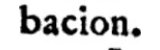

In [44]:
padding_color: typing.Tuple[int] = (255, 255, 255)
input_dirs = ["/kaggle/working/inf_words"]
image_paths = []

for input_dir in input_dirs:
    if os.path.exists(input_dir): 
        images = [os.path.join(input_dir, img) for img in os.listdir(input_dir)
                  if img.endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(images) 
    else:
        print(f"Warning: Directory {input_dir} does not exist.")

print(f"Total images collected: {len(image_paths)}")


# Applying padding to each image
output_dir = "/kaggle/working/inf_images" 
os.makedirs(output_dir, exist_ok=True) 

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Skipping {img_path}, could not load image.")
        continue

    old_h, old_w = img.shape[:2]

    # Resizing while maintaining aspect ratio
    ratio = min(target_w / old_w, target_h / old_h)
    new_w, new_h = int(old_w * ratio), int(old_h * ratio)
    resized_image = cv2.resize(img, (new_w, new_h))

    # computing padding
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Applying padding
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    
    gray_padded_image = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)
    
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(output_path, gray_padded_image)

print(f"Saved: {output_path}")
#exampple image
cv2_imshow(gray_padded_image)


In [45]:
inf_dataset = tf.data.Dataset.from_tensor_slices((np.array(inf_df['Image_Path'].to_list()), np.array(inf_df['Label'].to_list()))
).map(process_sample, num_parallel_calls=autotune).batch(batch_size).prefetch(autotune)

In [46]:
print(f"inference data Size : {tf.data.Dataset.cardinality(inf_dataset).numpy() * batch_size}")

inference data Size : 200


# Predictions on inference data

In [47]:
predictions = convert_predictions_to_text(inference_model.predict(inf_dataset))
true = inf_df['Label'].tolist()   #convert to test_ds

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


### Displaying each true label vs predicted label

In [48]:
predictions = convert_predictions_to_text(inference_model.predict(inf_dataset))
print("True -> Predicted")
print("-----------------")
for true_label, pred_label in zip(inf_df["Label"], predictions):
    print(f"{true_label} -> {pred_label}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
True -> Predicted
-----------------
MOTIVO -> OrNO
DEL -> DEL
AUTHOR, -> PTTIOI
Y -> Y
RAZON -> AAgos
‘de -> e
la -> la
Obra. -> Gbra.
A -> A.
devocion -> devocion
, -> ,
y -> y
afe&to, -> afeto,
que -> que
defde -> defde
mis -> mis
L -> .
tiernos -> tiernos
ahos -> afios
profefse -> profefse
4 -> 4
la -> la
Sagrada -> Sagrada
Religion -> Religion
de -> de
la -> la
Compafia -> Compatiia
de -> de
Jesus, -> Jesvs,
y -> y
la -> la
profeflaré -> profeflare
eternamente -> eermamente
, -> ,
como -> como
hijo -> hijo
el -> el
mas -> mas
reconocido -> reconocido
a -> 4
tan -> tan
efcogida -> efcogida
Madre -> Madre
: -> :
me -> ‘e
obligo -> obligo
a -> 4
efcrivir -> efcrivir
, -> ,
y -> y
dar -> dar
ala -> ala
Eftampa -> Eftampa
efta -> efta
Inftruccion -> Inftruccion
para -> Para
fus -> fus
Sefores -> Sefiores
Colegiales, -> Colegiales,
fin -> fin
que -> que
por -> por
effo -> efo
fe -> fe
niegue -> niegue
a -> 4
fervir -> fervir
a -> 4
los -> los
de- -

# Evaluation metrics


#### CTC Loss

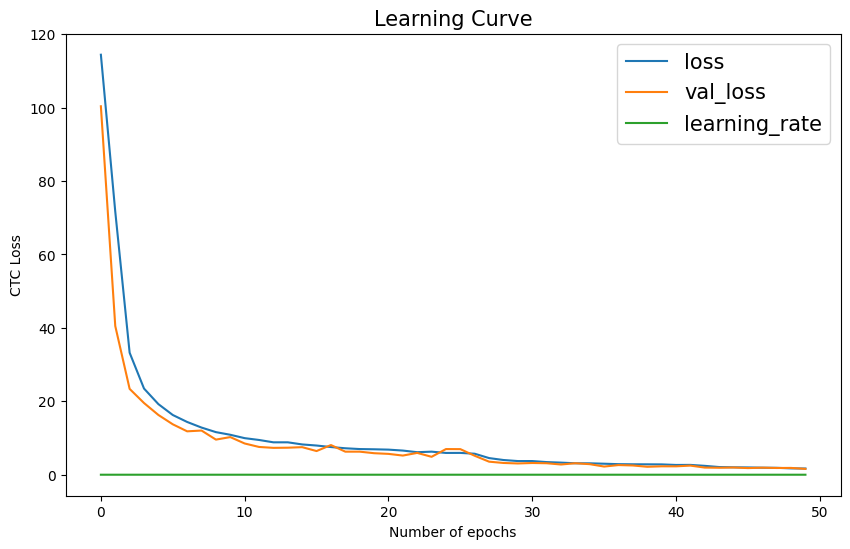

In [49]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.legend(fontsize=15)
plt.title("Learning Curve", fontsize=15)
plt.xlabel("Number of epochs")
plt.ylabel("CTC Loss")
plt.show()

#### Character error rate 
#### Word error rate
#### Accuracy

In [50]:
from jiwer import cer,wer
from sklearn.metrics import accuracy_score

def calculate_cer_jiwer(predictions_list, true_list):
    return cer(true_list, predictions_list)

def calculate_wer_jiwer(predictions_list, true_list):
    return wer(true_list, predictions_list)

def calculate_accuracy_jiwer(predictions_list, true_list):
    return accuracy_score(true_list, predictions_list)

# Calculate CER and Accuracy
wer_value = calculate_wer_jiwer(predictions, true)
cer_value = calculate_cer_jiwer(predictions, true)
accuracy_value = calculate_accuracy_jiwer(predictions, true)

print(f"Word Error Rate (WER): {wer_value * 100:.3f} %")
print(f"Character Error Rate (CER): {cer_value * 100:.3f} %")
print(f"Accuracy: {accuracy_value * 100:.2f} %")


Word Error Rate (WER): 23.737 %
Character Error Rate (CER): 8.434 %
Accuracy: 76.26 %


## Improving accuracy using constrained beam search

### Preparing the custom lexicon from a collection of renaissance spanish words. These words were collected from different transcriptions and stored in a docx file initially

In [51]:
import docx

def extract_words(docx_path):
    doc = docx.Document(docx_path)
    full_text = " ".join([para.text for para in doc.paragraphs])  
    words = full_text.split() 
    words = [word.strip(",.?!;:()[]{}'\"").lower() for word in words]  
    return set(words)  

docx_path = "/kaggle/input/lexicon-spanish/lexicon_big.docx"
custom_lexicon = extract_words(docx_path)

with open("custom_lexicon.txt", "w") as f:
    for word in sorted(custom_lexicon):
        f.write(word + "\n")

print(f"Lexicon saved with {len(custom_lexicon)} unique words.")


Lexicon saved with 3747 unique words.


In [52]:
%pip install pybktree python-Levenshtein

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for pybktree: filename=pybktree-1.1-py3-none-any.whl size=4948 sha256=b7356b7183a288236aded2d8bd8723d6a46436ba0c5e302a23d7504fd52985f0
  Stored in directory: /root/.cache/pip/wheels/09/97/f5/14ae07459879c2738cfa34f61a8d3d2d99b13e15328bc6d1dc
Successfully built pybktree
Note: you may need to restart the kernel to use updated packages.


### Applying contrained beam search on predicted labels and lexicon

In [53]:
import pybktree
import Levenshtein

def levenshtein_distance(a, b):
    return Levenshtein.distance(a, b)

def build_bk_tree(lexicon):
    return pybktree.BKTree(levenshtein_distance, lexicon)

def constrained_beam_search(predicted_labels, true_labels, bk_tree, max_edit_distance=2):
    #Performs constrained beam search by replacing predicted words with the closest words from the lexicon using Levenshtein distance.
    corrected_predictions = []
    
    for pred_word, true_word in zip(predicted_labels, true_labels):
        # If prediction is already correct, I keep it
        if pred_word == true_word:
            corrected_predictions.append(pred_word)
            continue

        # Search for closest words in lexicon within max_edit_distance
        candidates = bk_tree.find(pred_word, max_edit_distance)
        
        if candidates:
            # Select the closest word (with the smallest edit distance)
            best_match = min(candidates, key=lambda x: x[0])[1]
            corrected_predictions.append(best_match)
        else:
            # If no close match found,I keep original prediction
            corrected_predictions.append(pred_word)
    
    return corrected_predictions

# storing our custom lexicon as the lexicon
lexicon = custom_lexicon

# building BK-tree from the lexicon
bk_tree = build_bk_tree(lexicon)

# predicted and true Labels
predicted_labels = predictions
true_labels = true

# performing Constrained Beam Search
corrected_predictions = constrained_beam_search(predicted_labels, true_labels, bk_tree, max_edit_distance=2)

# results
for pred, corrected in zip(predicted_labels, corrected_predictions):
    print(f"Predicted: {pred}  →  Corrected: {corrected}")


Predicted: OrNO  →  Corrected: OrNO
Predicted: DEL  →  Corrected: DEL
Predicted: PTTIOI  →  Corrected: PTTIOI
Predicted: Y  →  Corrected: Y
Predicted: AAgos  →  Corrected: rigos
Predicted: e  →  Corrected: e
Predicted: la  →  Corrected: la
Predicted: Gbra.  →  Corrected: bran
Predicted: A.  →  Corrected: 
Predicted: devocion  →  Corrected: devocion
Predicted: ,  →  Corrected: ,
Predicted: y  →  Corrected: y
Predicted: afeto,  →  Corrected: afectos
Predicted: que  →  Corrected: que
Predicted: defde  →  Corrected: defde
Predicted: mis  →  Corrected: mis
Predicted: .  →  Corrected: 
Predicted: tiernos  →  Corrected: tiernos
Predicted: afios  →  Corrected: ambos
Predicted: profefse  →  Corrected: profefse
Predicted: 4  →  Corrected: 4
Predicted: la  →  Corrected: la
Predicted: Sagrada  →  Corrected: Sagrada
Predicted: Religion  →  Corrected: Religion
Predicted: de  →  Corrected: de
Predicted: la  →  Corrected: la
Predicted: Compatiia  →  Corrected: Compatiia
Predicted: de  →  Corrected: de

## Final metrics after constrained beam search

In [54]:
# Calculate CER and Accuracy after applying constrained beam search decoding
wer_value = calculate_wer_jiwer(corrected_predictions, true)
cer_value = calculate_cer_jiwer(corrected_predictions, true)
accuracy_value = calculate_accuracy_jiwer(corrected_predictions, true)

print(f"Word Error Rate (WER): {wer_value * 100:.3f} %")
print(f"Character Error Rate (CER): {cer_value * 100:.3f} %")
print(f"Accuracy: {accuracy_value * 100:.2f} %")


Word Error Rate (WER): 21.717 %
Character Error Rate (CER): 10.000 %
Accuracy: 78.28 %
